In [2]:
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.dynamics import DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import TSIT5
from odisseo.initial_condition import Plummer_sphere
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.utils import projection_on_GD1
from odisseo.visualization import energy_angular_momentum_plot

import galpy




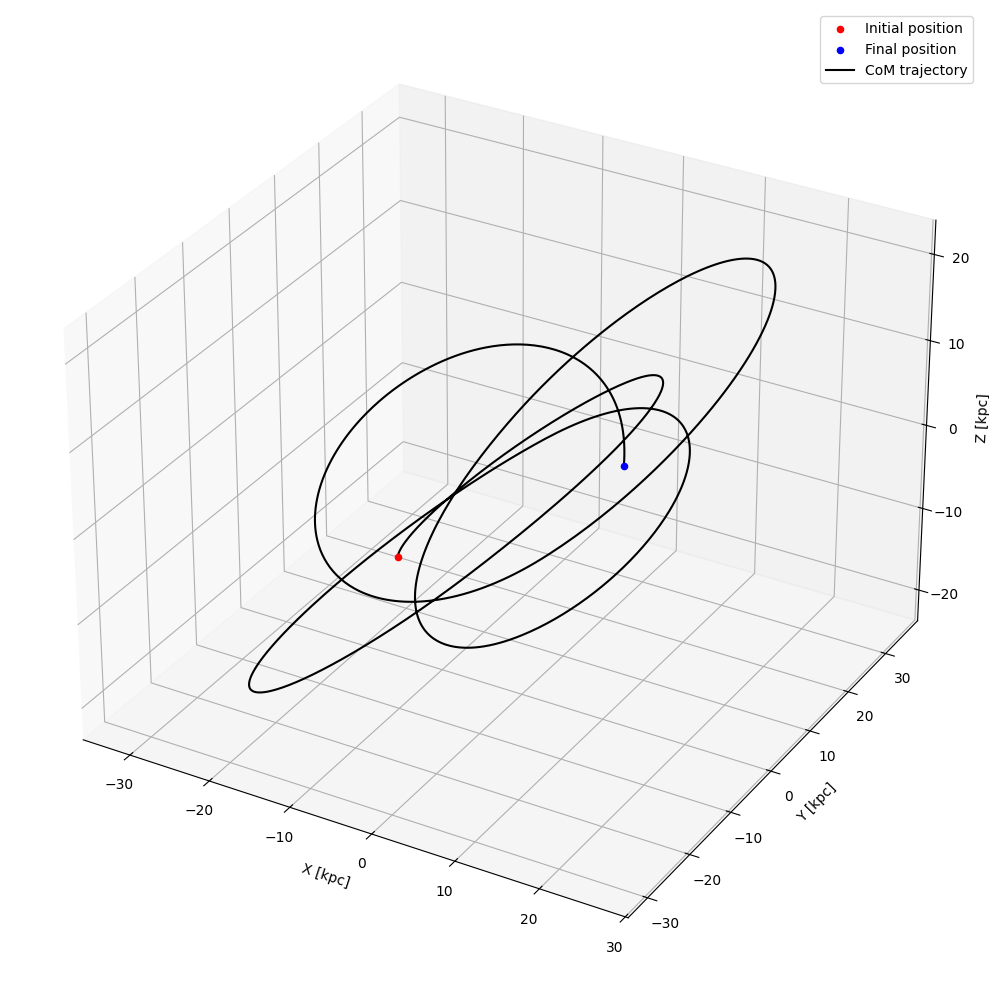

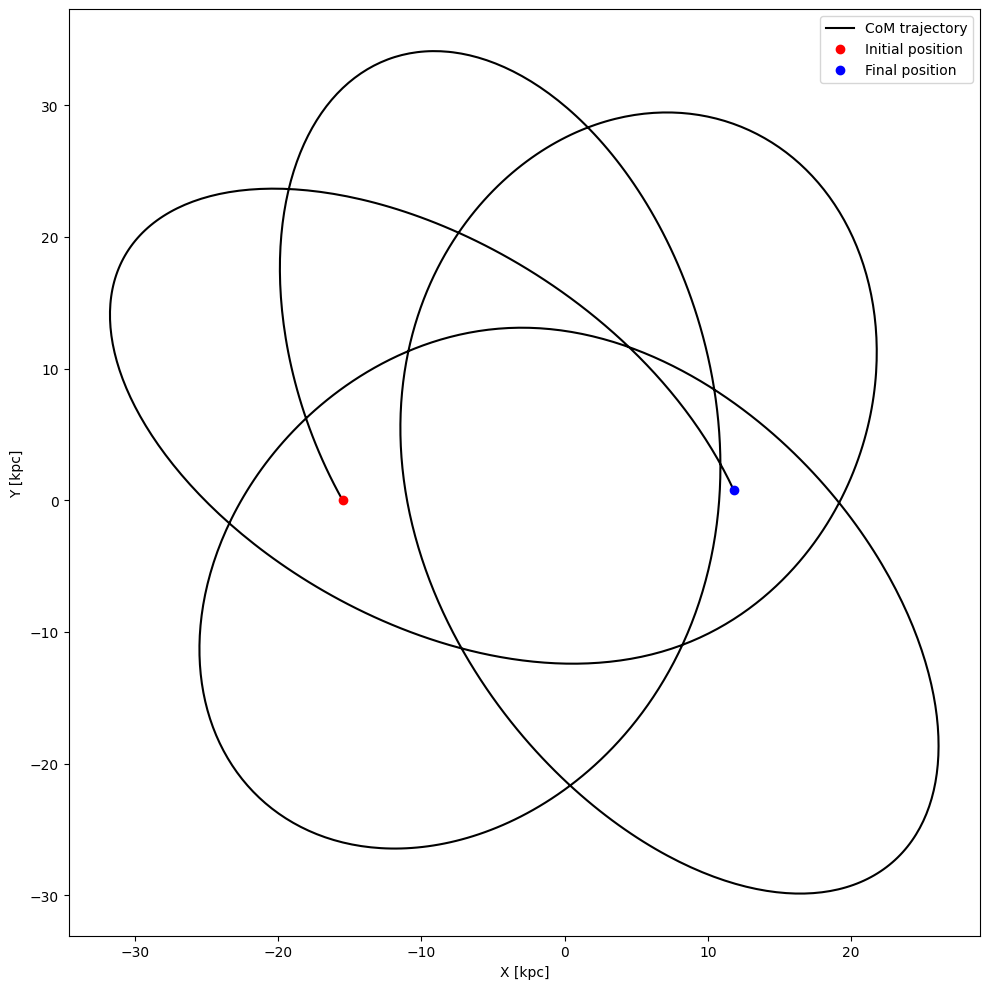

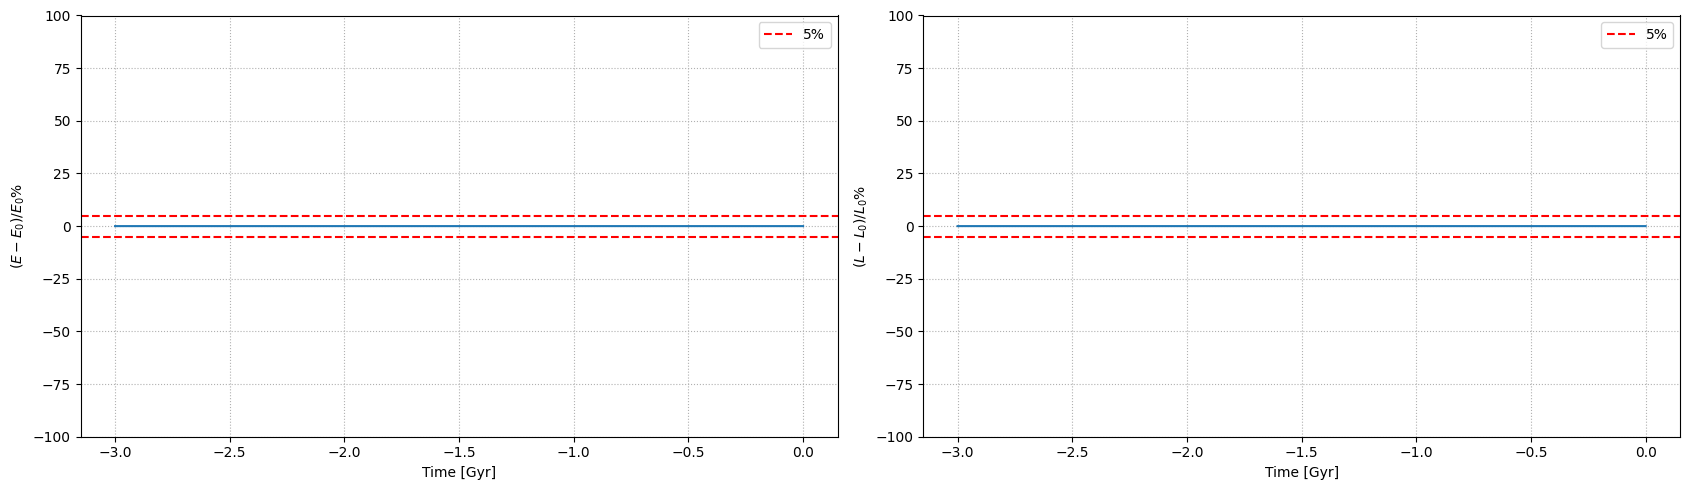

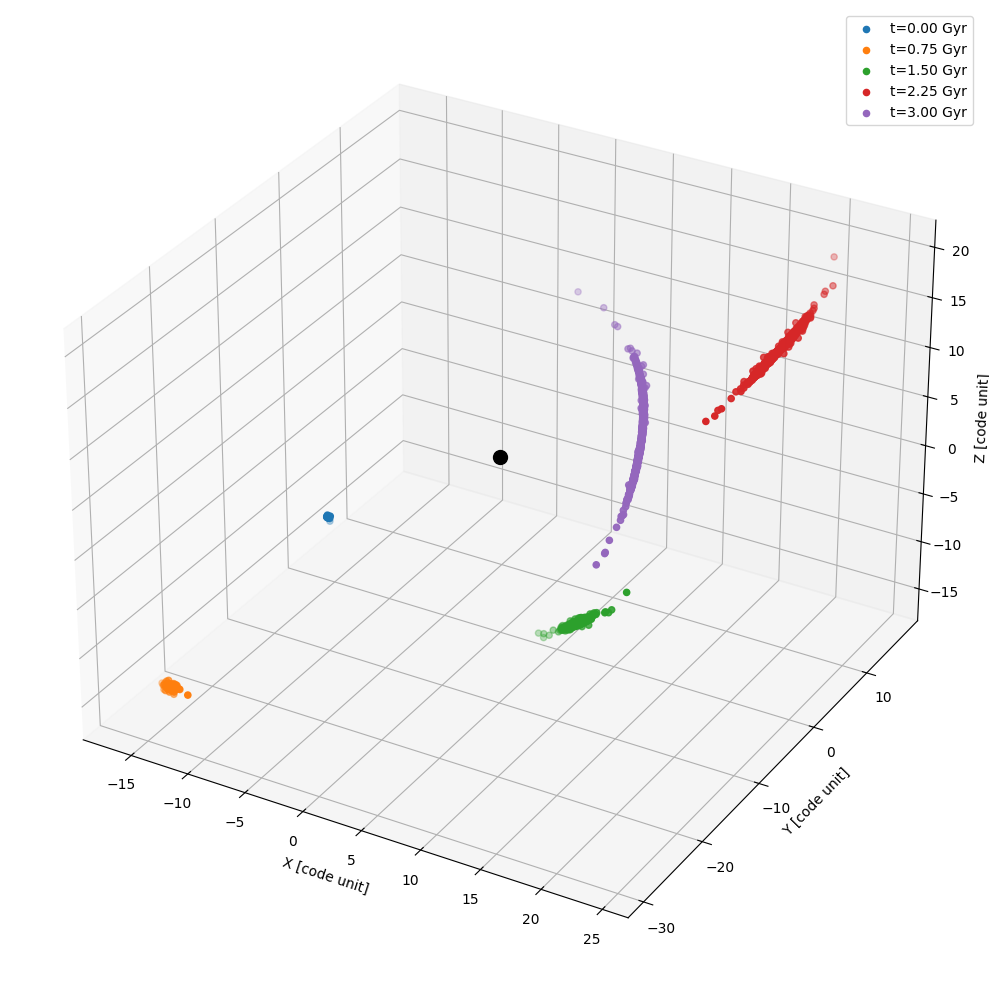

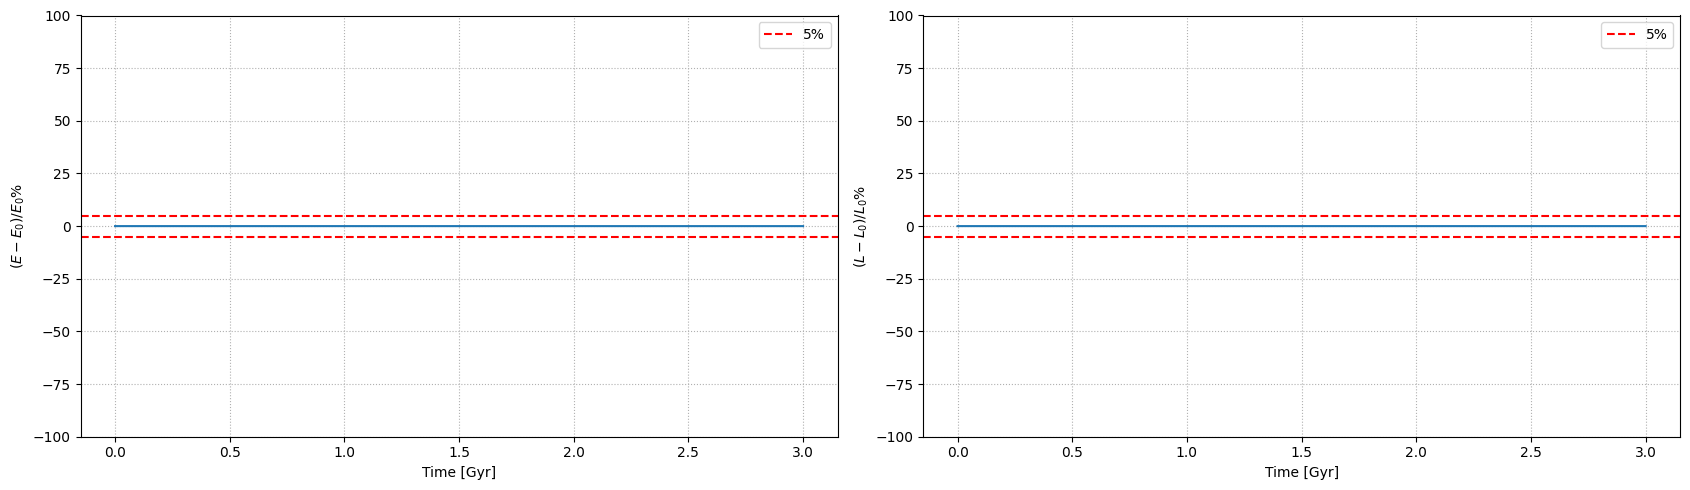

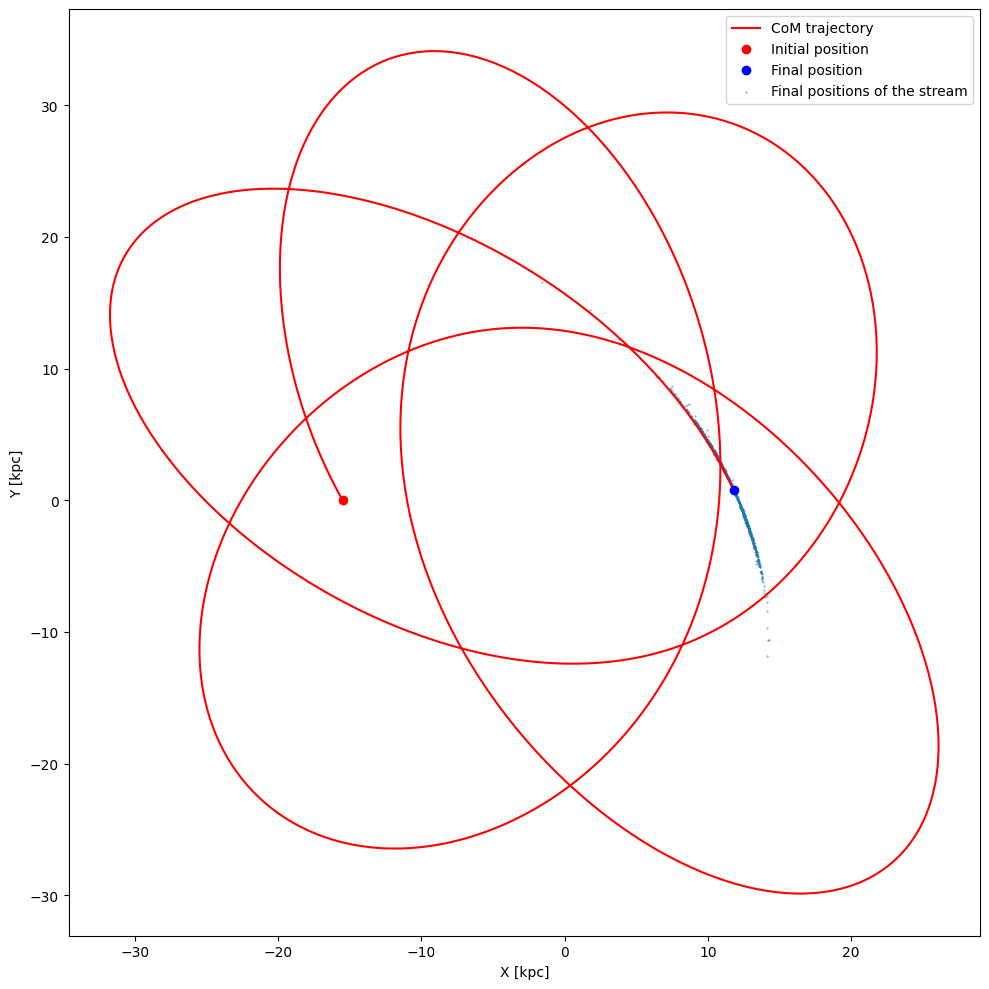

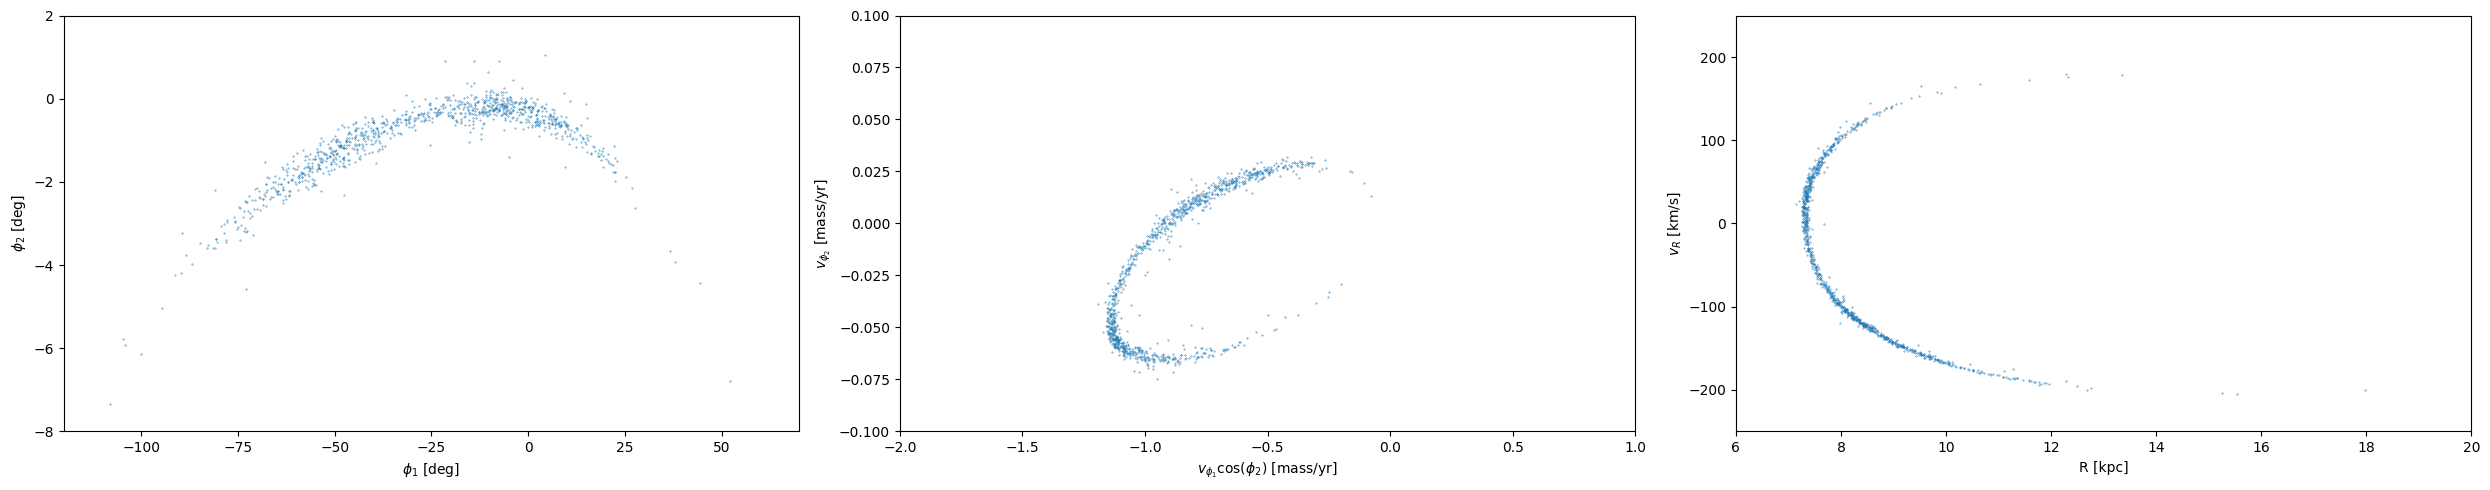

In [3]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

def generate_noise_fixed(key, N_particles):
    """Generate fixed noise for reproducible results"""
    keys = random.split(key, 6)
    noise = jnp.column_stack([
        random.uniform(keys[0], shape=(N_particles,)),  # r
        random.uniform(keys[1], shape=(N_particles,)),  # phi
        random.uniform(keys[2], shape=(N_particles,)),  # sin_i  
        random.uniform(keys[3], shape=(N_particles,)),  # u
        random.uniform(keys[4], shape=(N_particles,)),  # phi_v
        random.uniform(keys[5], shape=(N_particles,))   # sin_i_v
    ])
    return noise


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
# config_com = config._replace(return_snapshots=True,)
# config_com = config._replace(num_snapshots=500, )
params_com = params._replace(t_end=-params.t_end,)



#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)


#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)


fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
# ax.set_zlim(-30, 30)
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots.states[-1, :, 0, 1]* code_units.code_length.to(u.kpc), s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
ax.legend()



final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)


s = projection_on_GD1(final_state, code_units=code_units,)
R = s[:, 0]  # kpc
phi1 = s[:, 1]  # deg
phi2 = s[:, 2]  # deg
vR = s[:, 3]  # km/s
v1_cosphi2 = s[:, 4]  # mass/yr
v2 = s[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


stream_target = s

In [4]:
initial_state_stream.shape

(1000, 2, 3)

## Stäckel fudge AGAMA

In [6]:
final_state_com

Array([[[  1.1800001 ,   0.079     ,   0.64000005],
        [ 33.596096  , -78.084076  , -27.705275  ]]], dtype=float32)

(1000, 6)
1000


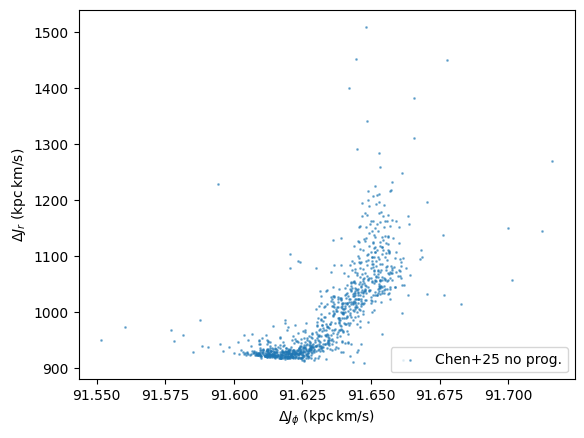

In [16]:
import agama # to calculate action
agama.setUnits(length=1, velocity=1, mass=1) # working units: 1 Msun, 1 kpc, 1 km/s

actFinder = agama.ActionFinder(agama.Potential('./MWPotential2024.ini'))

def get_action(actFinder):
    pos_prog = np.array(pos_com_final)
    vel_prog = np.array(vel_com_final)
    posvel_prog = np.r_[pos_prog.squeeze(),vel_prog.squeeze()]
    action_prog = actFinder(posvel_prog)
    Jphi_prog = action_prog[2]
    Jr_prog = action_prog[0]

    pos = np.array(final_positions)
    vel = np.array(final_velocities)
    posvel = np.column_stack((pos,vel))
    print(posvel.shape)
    actions, angles, freqs = actFinder(posvel, angles=True, )
    print(len(actions))
    Jphi = actions[:,2]
    Jr = actions[:,0]
    last_J =actions[:, 1]
    
    # DLtot = Ltot - Ltot_prog
    DJphi = Jphi - Jphi_prog
    DJr = Jr - Jr_prog
    return DJphi, DJr, Jphi, Jr, last_J, Jphi_prog, Jr_prog, action_prog, actions, angles, freqs
    
# DJphi, DJr = get_action(stream_f15, prog_f15, actFinder)
# plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Fardal+15')

DJphi, DJr, Jphi, Jr, last_J, Jphi_prog, Jr_prog, action_prog, actions, angles, freqs = get_action(actFinder)
plt.figure()
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+25 no prog.')
plt.xlabel(r'$\Delta J_\phi\ ({\rm kpc\,km/s})$')
plt.ylabel(r'$\Delta J_r\ ({\rm kpc\,km/s})$')
plt.legend(loc='lower right')
plt.show()



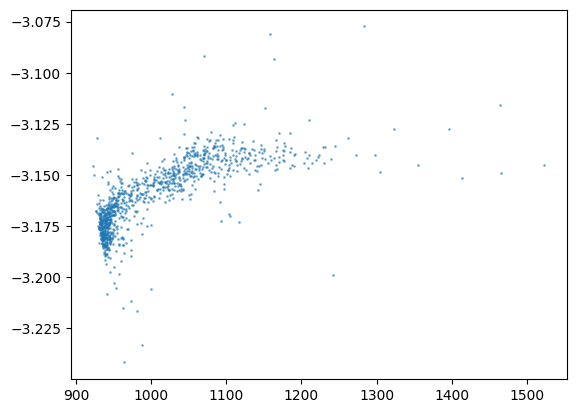

In [17]:
plt.scatter(actions[:,0], actions[:,2], s=1, alpha=0.5)

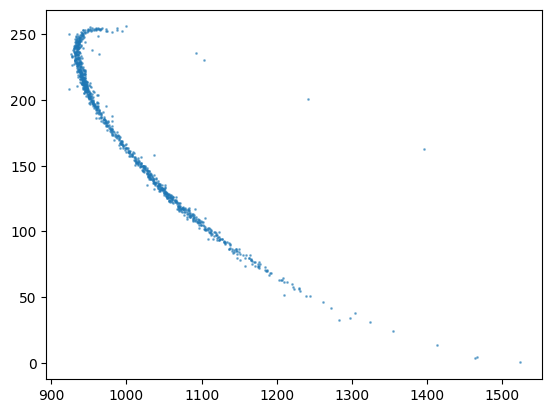

In [18]:
plt.scatter(actions[:,0], actions[:,1], s=1, alpha=0.5)

# Using Staeckel Fudge

## Initial-state stream

3


Text(0, 0.5, 'Lz')

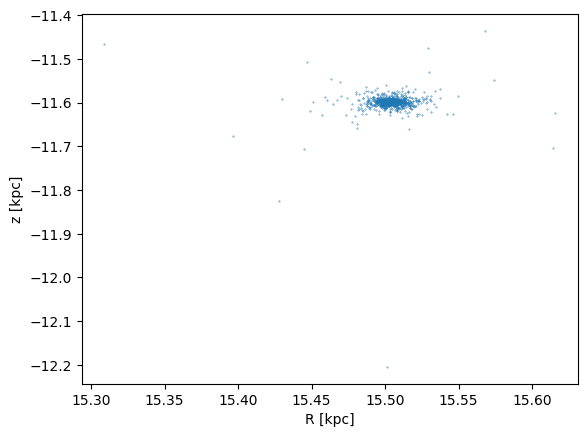

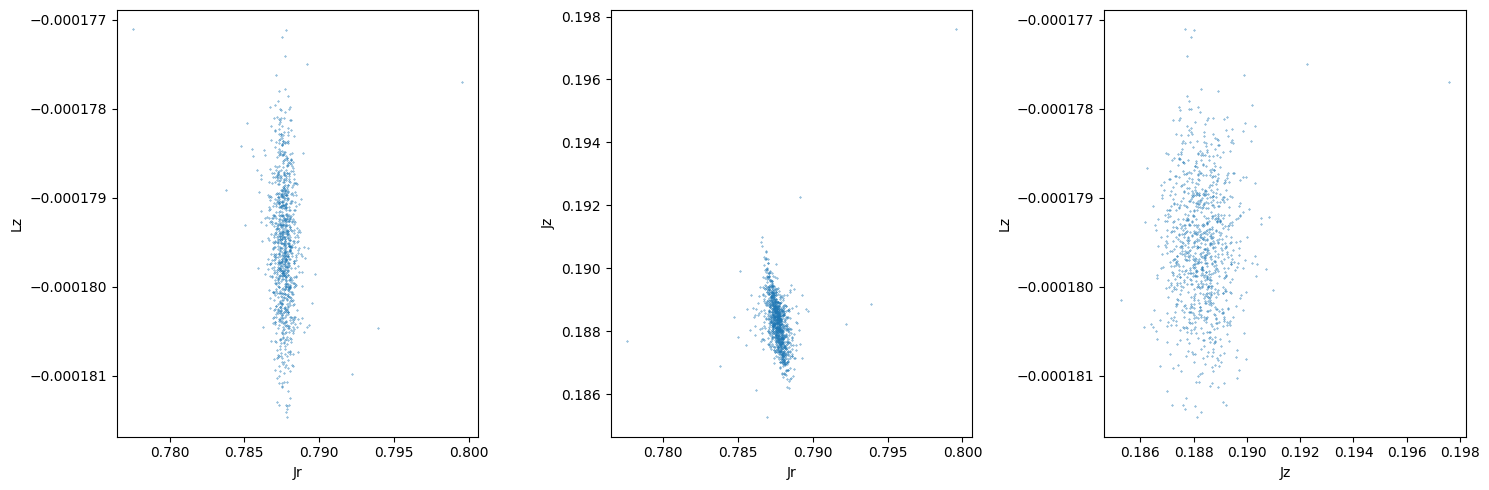

In [ ]:
import jax.numpy as jnp

def cartesian_to_cylindrical(cartesian_coords,):
    x = cartesian_coords[0]
    y = cartesian_coords[1]
    z = cartesian_coords[2]
    vx = cartesian_coords[3]
    vy = cartesian_coords[4]
    vz = cartesian_coords[5]

    z = z * code_units.code_length.to(u.kpc)
    R = jnp.sqrt(x**2 + y**2) * code_units.code_length.to(u.kpc)
    vR = (x * vx + y * vy) / R * code_units.code_velocity.to(u.kpc / u.Myr)
    vT = (x * vy - y * vx) / R * code_units.code_velocity.to(u.kpc / u.Myr)
    phi = jnp.arctan2(y, x)
    return jnp.array([R, z, vR, vz, vT, phi])

initial_state_stream_shaped_correct = initial_state_stream.reshape(-1, 6)
cylindrical_coord = cartesian_to_cylindrical(initial_state_stream_shaped_correct.T)
cylindrical_coord = np.array(cylindrical_coord)

plt.scatter(cylindrical_coord[0], cylindrical_coord[1], s=0.1)
plt.xlabel("R [kpc]")
plt.ylabel("z [kpc]")

from galpy.actionAngle import actionAngleStaeckel
aAS = actionAngleStaeckel(pot=galpy.potential.MWPotential2014, delta=0.4, c=True)

action_angle = aAS(cylindrical_coord[0] * u.kpc, cylindrical_coord[2] * (u.km/u.s), cylindrical_coord[4] * (u.km/u.s), cylindrical_coord[1] * u.kpc, cylindrical_coord[3] * (u.km/u.s), )
print(len(action_angle))

Jr = action_angle[0]
lz = action_angle[1]
Jz = action_angle[2]
fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax = fig.add_subplot(131)
ax.scatter(Jr, lz, s=0.1)
ax.set_xlabel("Jr")
ax.set_ylabel("Lz")
ax = fig.add_subplot(132)
ax.scatter(Jr, Jz, s=0.1)
ax.set_xlabel("Jr")
ax.set_ylabel("Jz")
ax = fig.add_subplot(133)
ax.scatter(Jz, lz, s=0.1)
ax.set_xlabel("Jz")
ax.set_ylabel("Lz")



## Final state stream

3


Text(0, 0.5, 'Lz')

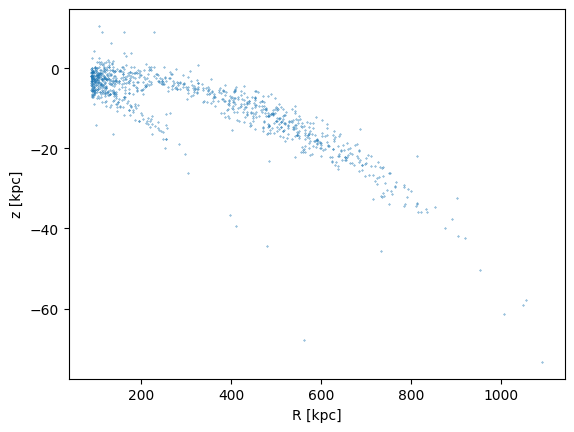

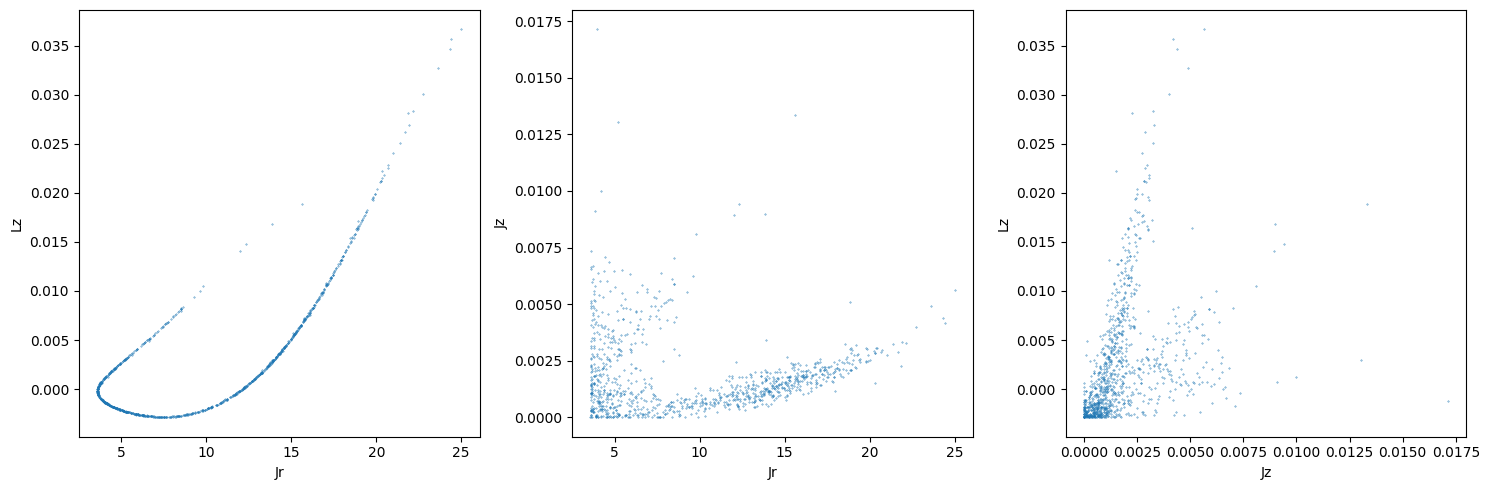

In [60]:
import jax.numpy as jnp

def cartesian_to_cylindrical(cartesian_coords,):
    x = cartesian_coords[0]
    y = cartesian_coords[1]
    z = cartesian_coords[2]
    vx = cartesian_coords[3]
    vy = cartesian_coords[4]
    vz = cartesian_coords[5]

    z = z * code_units.code_length.to(u.kpc)
    R = jnp.sqrt(x**2 + y**2) * code_units.code_length.to(u.kpc)
    vR = (x * vx + y * vy) / R * code_units.code_velocity.to(u.kpc / u.Myr)
    vT = (x * vy - y * vx) / R * code_units.code_velocity.to(u.kpc / u.Myr)
    phi = jnp.arctan2(y, x)
    return jnp.array([R, z, vR, vz, vT, phi])

cylindrical_coord = cartesian_to_cylindrical(stream_target.T  )
cylindrical_coord = np.array(cylindrical_coord)

plt.scatter(cylindrical_coord[0], cylindrical_coord[1], s=0.1)
plt.xlabel("R [kpc]")
plt.ylabel("z [kpc]")

from galpy.actionAngle import actionAngleStaeckel
aAS = actionAngleStaeckel(pot=galpy.potential.MWPotential2014, delta=0.4, c=True)

action_angle = aAS(cylindrical_coord[0] * u.kpc, cylindrical_coord[2] * (u.km/u.s), cylindrical_coord[4] * (u.km/u.s), cylindrical_coord[1] * u.kpc, cylindrical_coord[3] * (u.km/u.s), )
print(len(action_angle))

Jr = action_angle[0]
lz = action_angle[1]
Jz = action_angle[2]
fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax = fig.add_subplot(131)
ax.scatter(Jr, lz, s=0.1)
ax.set_xlabel("Jr")
ax.set_ylabel("Lz")
ax = fig.add_subplot(132)
ax.scatter(Jr, Jz, s=0.1)
ax.set_xlabel("Jr")
ax.set_ylabel("Jz")
ax = fig.add_subplot(133)
ax.scatter(Jz, lz, s=0.1)
ax.set_xlabel("Jz")
ax.set_ylabel("Lz")



# Orbit_integration action angle

## Progenitor stream

3


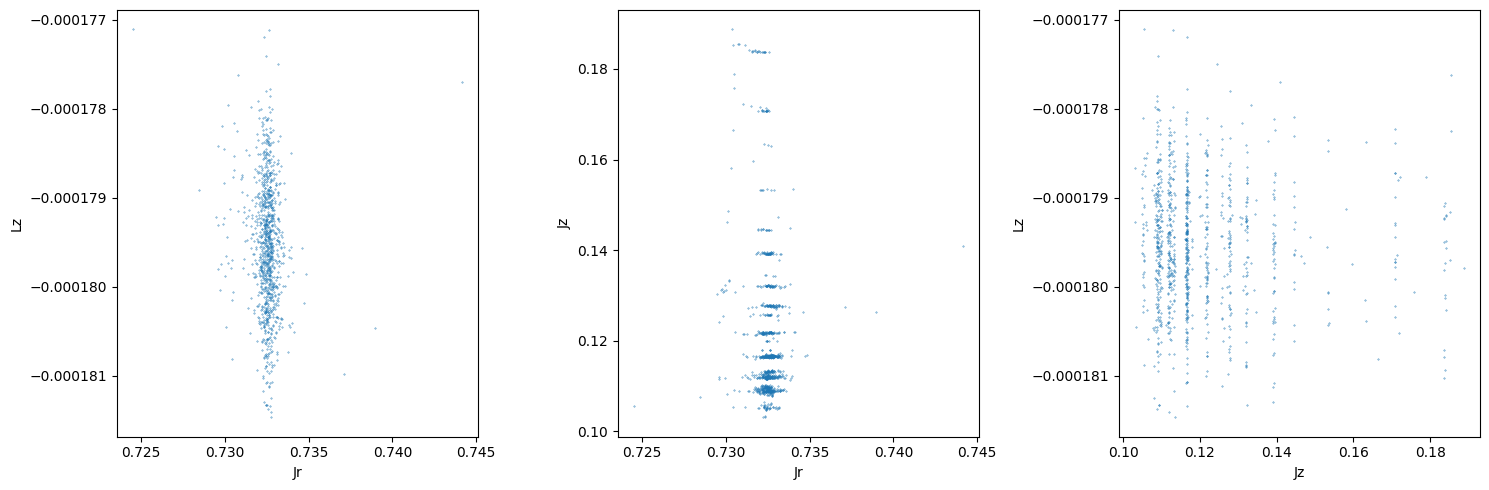

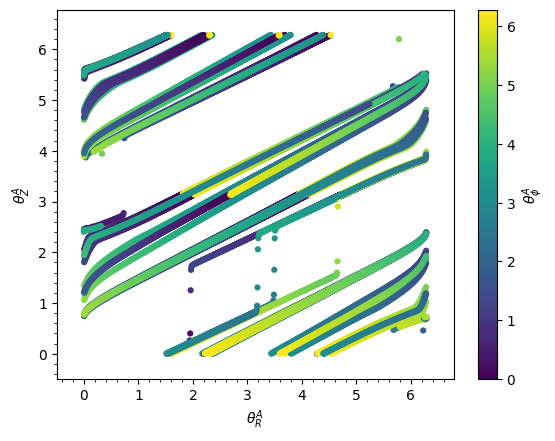

In [65]:
from galpy.actionAngle import actionAngleIsochroneApprox

def cartesian_to_cylindrical(cartesian_coords,):
    x = cartesian_coords[0]
    y = cartesian_coords[1]
    z = cartesian_coords[2]
    vx = cartesian_coords[3]
    vy = cartesian_coords[4]
    vz = cartesian_coords[5]

    z = z * code_units.code_length.to(u.kpc)
    R = jnp.sqrt(x**2 + y**2) * code_units.code_length.to(u.kpc)
    vR = (x * vx + y * vy) / R * code_units.code_velocity.to(u.kpc / u.Myr)
    vT = (x * vy - y * vx) / R * code_units.code_velocity.to(u.kpc / u.Myr)
    phi = jnp.arctan2(y, x)
    return jnp.array([R, z, vR, vz, vT, phi])

initial_state_stream_shaped_correct = initial_state_stream.reshape(-1, 6)
cylindrical_coord = cartesian_to_cylindrical(initial_state_stream_shaped_correct.T)

aAIA = actionAngleIsochroneApprox(pot=galpy.potential.MWPotential2014, b=0.8)
action_angle = aAIA(cylindrical_coord[0] * u.kpc, 
           cylindrical_coord[2] * (u.km/u.s), 
           cylindrical_coord[4] * (u.km/u.s), 
           cylindrical_coord[1] * u.kpc, 
           cylindrical_coord[3] * (u.km/u.s), 
           cylindrical_coord[5] * u.rad)
print(len(action_angle))

Jr = action_angle[0]
lz = action_angle[1]
Jz = action_angle[2]
fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax = fig.add_subplot(131)
ax.scatter(Jr, lz, s=0.1)
ax.set_xlabel("Jr")
ax.set_ylabel("Lz")
ax = fig.add_subplot(132)
ax.scatter(Jr, Jz, s=0.1)
ax.set_xlabel("Jr")
ax.set_ylabel("Jz")
ax = fig.add_subplot(133)
ax.scatter(Jz, lz, s=0.1)
ax.set_xlabel("Jz")
ax.set_ylabel("Lz")

action_angle = aAIA.plot(cylindrical_coord[0] * u.kpc, 
           cylindrical_coord[2] * (u.km/u.s), 
           cylindrical_coord[4] * (u.km/u.s), 
           cylindrical_coord[1] * u.kpc, 
           cylindrical_coord[3] * (u.km/u.s), 
           cylindrical_coord[5] * u.rad)

## Final stream

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/galpy/actionAngle/actionAngleIsochrone.py:253: RuntimeWarning: invalid value encountered in sqrt
  Jr = self.amp / numpy.sqrt(-2.0 * E) - 0.5 * (

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/galpy/actionAngle/actionAngleIsochrone.py:257: RuntimeWarning: invalid value encountered in power
  Omegar = (-2.0 * E) ** 1.5 / self.amp

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/galpy/actionAngle/actionAngleIsochrone.py:282: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt((1.0 + e) / (1.0 - e)) * numpy.tan(0.5 * eta)

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/galpy/actionAngle/actionAngleIsochrone.py:285: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt((1.0 + e + 2.0 * self.b / c) / (1.0 - e + 2.0 * self.b / c))

3


Text(0, 0.5, 'Lz')

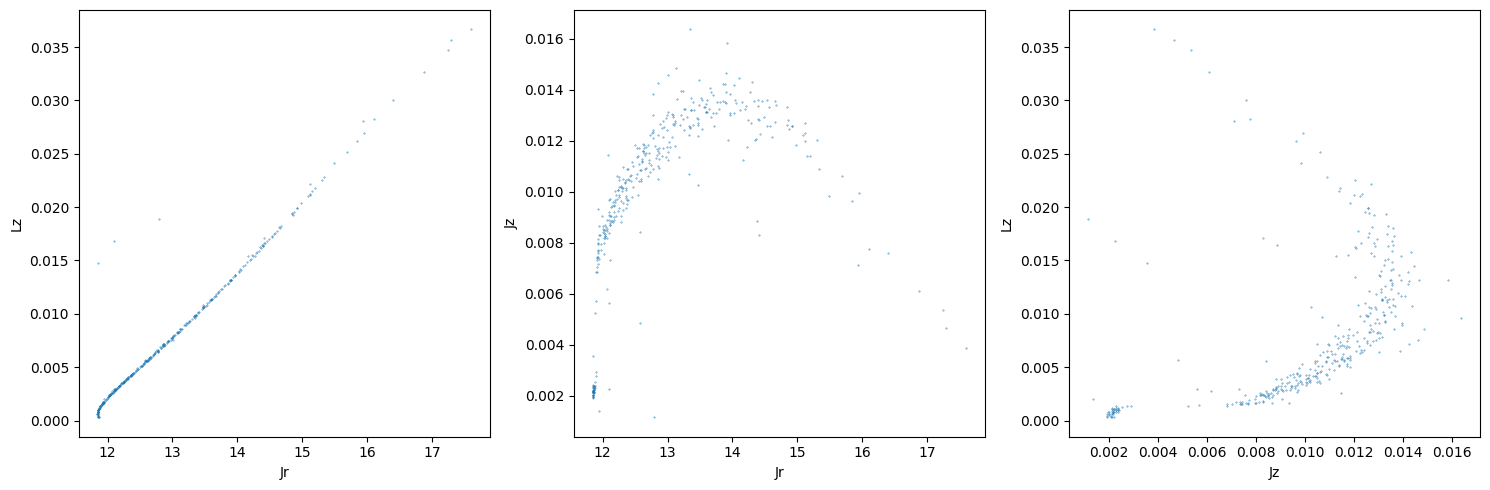

In [ ]:
from galpy.actionAngle import actionAngleIsochroneApprox

def cartesian_to_cylindrical(cartesian_coords,):
    x = cartesian_coords[0]
    y = cartesian_coords[1]
    z = cartesian_coords[2]
    vx = cartesian_coords[3]
    vy = cartesian_coords[4]
    vz = cartesian_coords[5]

    z = z * code_units.code_length.to(u.kpc)
    R = jnp.sqrt(x**2 + y**2) * code_units.code_length.to(u.kpc)
    vR = (x * vx + y * vy) / R * code_units.code_velocity.to(u.kpc / u.Myr)
    vT = (x * vy - y * vx) / R * code_units.code_velocity.to(u.kpc / u.Myr)
    phi = jnp.arctan2(y, x)
    return jnp.array([R, z, vR, vz, vT, phi])

cylindrical_coord = cartesian_to_cylindrical(stream_target.T  )
cylindrical_coord = np.array(cylindrical_coord)

aAIA = actionAngleIsochroneApprox(pot=galpy.potential.MWPotential2014, b=0.8)

action_angle = aAIA(cylindrical_coord[0] * u.kpc, 
           cylindrical_coord[2] * (u.km/u.s), 
           cylindrical_coord[4] * (u.km/u.s), 
           cylindrical_coord[1] * u.kpc, 
           cylindrical_coord[3] * (u.km/u.s), 
           cylindrical_coord[5] * u.rad)
print(len(action_angle))



Jr = action_angle[0]
lz = action_angle[1]
Jz = action_angle[2]
fig = plt.figure(figsize=(15, 5), tight_layout=True)
ax = fig.add_subplot(131)
ax.scatter(Jr, lz, s=0.1)
ax.set_xlabel("Jr")
ax.set_ylabel("Lz")
ax = fig.add_subplot(132)
ax.scatter(Jr, Jz, s=0.1)
ax.set_xlabel("Jr")
ax.set_ylabel("Jz")
ax = fig.add_subplot(133)
ax.scatter(Jz, lz, s=0.1)
ax.set_xlabel("Jz")
ax.set_ylabel("Lz")

action_angle = aAIA.plot(cylindrical_coord[0] * u.kpc, 
           cylindrical_coord[2] * (u.km/u.s), 
           cylindrical_coord[4] * (u.km/u.s), 
           cylindrical_coord[1] * u.kpc, 
           cylindrical_coord[3] * (u.km/u.s), 
           cylindrical_coord[5] * u.rad)

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/galpy/actionAngle/actionAngleIsochrone.py:253: RuntimeWarning: invalid value encountered in sqrt
  Jr = self.amp / numpy.sqrt(-2.0 * E) - 0.5 * (

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/galpy/actionAngle/actionAngleIsochrone.py:257: RuntimeWarning: invalid value encountered in power
  Omegar = (-2.0 * E) ** 1.5 / self.amp

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/galpy/actionAngle/actionAngleIsochrone.py:282: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt((1.0 + e) / (1.0 - e)) * numpy.tan(0.5 * eta)

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/galpy/actionAngle/actionAngleIsochrone.py:285: RuntimeWarning: invalid value encountered in sqrt
  numpy.sqrt((1.0 + e + 2.0 * self.b / c) / (1.0 - e + 2.0 * self.b / c))



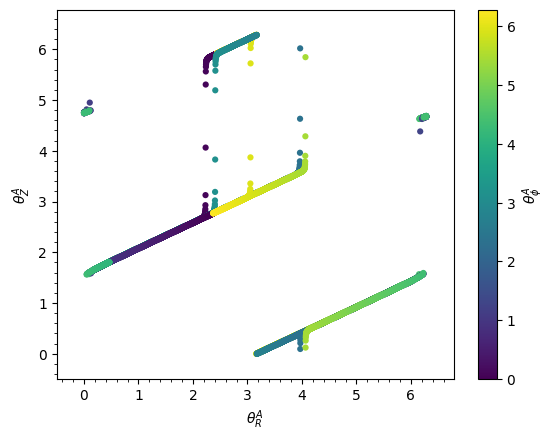